In [1]:
import pymc3 as pm
import numpy as np
import theano

from theano.compile.ops import as_op

In [2]:
def background_rate_f(b, T, n):
    """
    
    """
    out = 0
    #n = int(n)
    for i in range(n+1):
        out += ((b*T)**i * np.exp(- b*T)) / np.math.factorial(i)
    return out

def log_background_rate(b, T, n):
    return np.log(background_rate_f(b, T, n))

def signal_rate_part(s, n, b, T):
    top_a = T * ((s + b) * T)**n 
    top_b = np.exp(-(s + b)*T)
    p = (top_a * top_b) / np.math.factorial(n)
    return theano.tensor.switch(theano.tensor.le(s, 0), 0, p)

#@as_op(itypes=[T.dscalar, T.dscalar, T.dscalar, T.dscalar], otypes=[T.dscalar])
def log_signal_rate(s,n,b,T):
    #if theano.tensor.lt(0, s): return np.array([[0.0]])
    p = -log_background_rate(b,T,n) + np.log(signal_rate_part(s,n,b,T))
    
    return p

In [3]:
def number_mweg(horizon):
    return 4./3 * np.pi * horizon**3 *(2.26)**-3  #* (0.0116) #* horizon**3

In [4]:
import theano.tensor as T
from pymc3 import DensityDist, Uniform, Normal
from pymc3 import Model
from pymc3 import distributions


with Model() as model:
    number_events = 0
    background_rate = 0.01 #
    observation_time = 46.1/365. # 
    duty_cycle = 0.2
    horizon = 73.2    
    grb_rate = 1.0
    
    #trunc = pm.Bound(pm.DensityDist, lower=0)
    signal_rate = pm.DensityDist('signal_rate', 
                        logp=lambda value: log_signal_rate(value, number_events, background_rate, observation_time),
                       testval=10)
    
    n_galaxy = number_mweg(horizon)
    
    cbc_rate = pm.Deterministic('cbc_rate', signal_rate * n_galaxy * horizon)
    
    efficiency = pm.Uniform('efficiency', 0,1)
   
    costheta = pm.Deterministic('cos_angle', 1.0 - ((grb_rate/cbc_rate*efficiency)))
    
    angle = pm.Deterministic("angle", theano.tensor.arccos(costheta))

In [5]:
import theano.tensor as T
from pymc3 import DensityDist, Uniform, Normal
from pymc3 import Model
from pymc3 import distributions

def grb_model(number_events, background_rate, 
              observation_time, horizon, grb_rate,
             efficiency_prior = "uniform"):
    with Model() as model:
        signal_rate = pm.DensityDist('signal_rate', 
                            logp=lambda value: log_signal_rate(value, number_events, background_rate, observation_time),
                           testval=50)

        n_galaxy = number_mweg(horizon)

        cbc_rate = pm.Deterministic('cbc_rate', signal_rate * n_galaxy)

        # Allow the efficiency prior to be switched-out
        if efficiency_prior == "uniform":
            efficiency = pm.Uniform('efficiency', 0,1)
        elif efficiency_prior == "jeffreys":
            efficiency = pm.Beta('efficiency', 0.5, 0.5)
        elif isinstance(efficiency_prior, float):
            efficiency = efficiency_prior

        costheta = pm.Deterministic('cos_angle', 1.0 - ((grb_rate/cbc_rate*efficiency)))

        angle = pm.Deterministic("angle", theano.tensor.arccos(costheta))
        
        return model

In [19]:
priors = ["uniform", "jeffreys", 1.0, 0.5]

In [20]:
# O1 Scenarios
number_events = 0 # There were no BNS detections in O1
background_rate = 0.01 # We take the FAR to be 1/100 yr
observation_time = 46.1/365. # The number of days of analysis conducted by gstLAL
horizon = 73.2  # The O1 BNS horizon distance in O1 BNS paper
grb_rate = 10.0
o1_models = []
for prior in priors:
    o1_models.append( grb_model(number_events, background_rate, observation_time, horizon, grb_rate, prior))

In [21]:
# O2 Scenarios
number_events = 1 # Assume O2 will see one BNS observation
background_rate = 0.01 # We take the FAR to be 1/100 yr
observation_time = 0.5 # The number of days of analysis conducted by gstLAL
duty_cycle = 0.4
observation_time *= duty_cycle
horizon = 80.0  # The O1 BNS horizon distance in O1 BNS paper
grb_rate = 10.0
o2_models = []
for prior in priors:
    o2_models.append( grb_model(number_events, background_rate, observation_time, horizon, grb_rate, prior))

In [8]:
samples = 100000

In [23]:
o1_traces = []
for model in o1_models:
    with model:
        step = pm.Metropolis()
        o1_traces.append(pm.sample(samples, step))
    
o2_traces = []    
for model in o2_models:
    with model:
        step = pm.Metropolis()
        o2_traces.append(pm.sample(samples, step))


  7%|▋         | 7336/100000 [00:02<13:29, 114.46it/s]

 77%|███████▋  | 77464/100000 [00:15<00:04, 5557.05it/s]


100%|██████████| 100000/100000 [00:08<00:00, 12000.64it/s]


In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
o1_trace.varnames

['signal_rate', 'cbc_rate', 'cos_angle', 'angle']

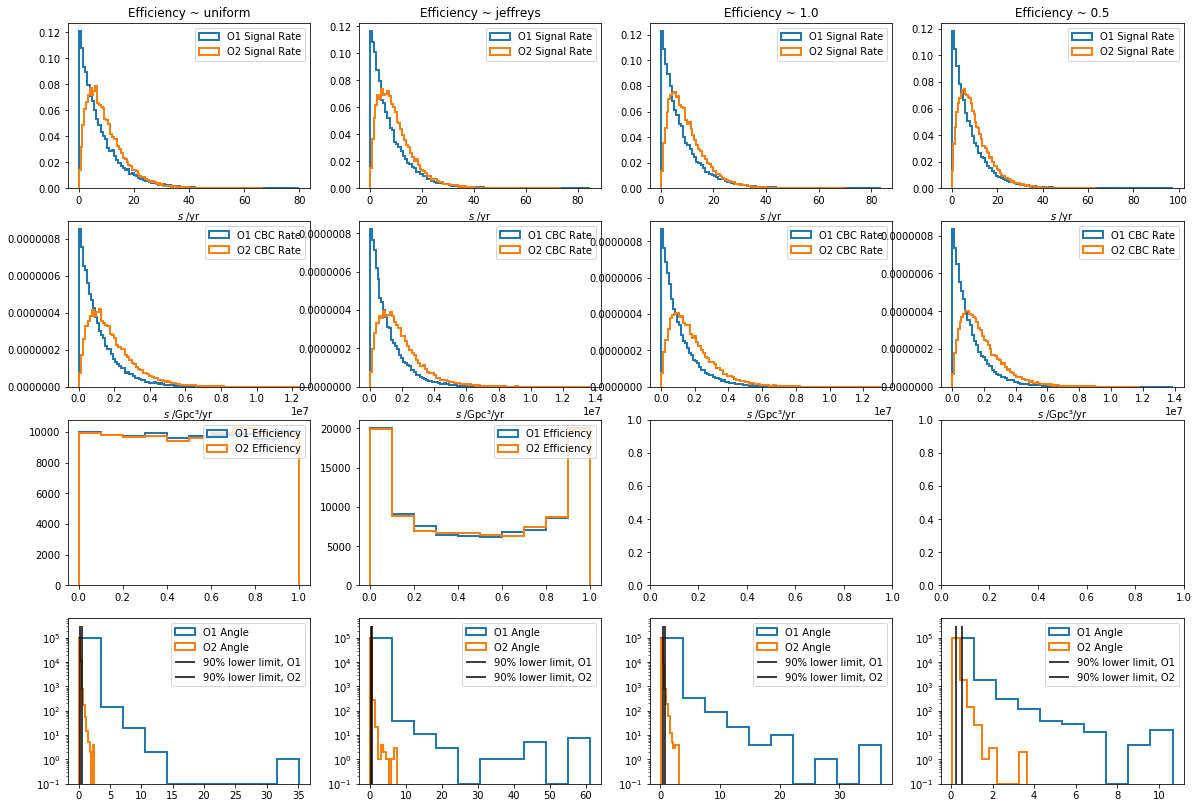

In [42]:

f, ax = plt.subplots(4,len(priors), figsize = (20, 14))
for i in range(len(priors)):

    o1_trace = o1_traces[i]
    o2_trace = o2_traces[i]

    ax[0,i].hist(o1_trace[2000:]['signal_rate'], histtype="step", label="O1 Signal Rate",
                 lw=2, normed=True, bins=100);
    ax[0,i].hist(o2_trace[2000:]['signal_rate'], histtype="step", label="O2 Signal Rate",
                 lw=2, normed=True, bins=100);
    #ax[0,0].vlines(np.percentile(trace['signal_rate'][2000:], 90), 0, 0.085,
    #              label = "90% lower limit");
    ax[0,i].set_title("Efficiency ~ {}".format(priors[i]));
    ax[0,i].set_xlabel("$s$ /yr")
    ax[0,i].legend()

    ax[1,i].hist(o1_trace[2000:]['cbc_rate'], histtype="step", lw=2, bins=100,
                 normed=True, label="O1 CBC Rate");
    ax[1,i].hist(o2_trace[2000:]['cbc_rate'], histtype="step", lw=2, bins=100,
                 normed=True, label="O2 CBC Rate");
    ax[1,i].set_xlabel(u"$s$ /Gpc³/yr");
    #ax[1,0].vlines(np.percentile(o1_trace['cbc_rate'][2000:], 90), 0, 5e-5,
    #              label = "90% lower limit, O1");
    #ax[1,0].vlines(np.percentile(o2_trace['cbc_rate'][2000:], 90), 0, 5e-5,
    #              label = "90% lower limit, O2", color="orange");
    ax[1,i].legend()
    try:
        ax[2,i].hist(o1_trace[2000:]['efficiency'], histtype="step", lw=2, label="O1 Efficiency");
        ax[2,i].hist(o2_trace[2000:]['efficiency'], histtype="step", lw=2, label="O2 Efficiency");
        #ax[1,0].set_xlabel(u"$s$ /Gpc³/yr")
        ax[2,i].legend()
    except KeyError:
        pass

    ax[3,i].hist(np.rad2deg(o1_trace[2000:]['angle'][np.isfinite(o1_trace[2000:]['angle'])]),
               histtype="step", lw=2, label="O1 Angle", log=True);
    ax[3,i].hist(np.rad2deg(o2_trace[2000:]['angle'][np.isfinite(o2_trace[2000:]['angle'])]),
               histtype="step", lw=2, label="O2 Angle", log=True);
    ax[3,i].vlines(np.percentile(np.rad2deg(o1_trace[2000:]['angle'][np.isfinite(o1_trace[2000:]['angle'])]), 90), 0, 3e5,
                  label = "90% lower limit, O1");
    ax[3,i].vlines(np.percentile(np.rad2deg(o2_trace[2000:]['angle'][np.isfinite(o2_trace[2000:]['angle'])]), 90), 0, 3e5,
                  label = "90% lower limit, O2");
    #ax[1,0].set_xlabel(u"$s$ /Gpc³/yr")
    ax[3,i].legend()

In [45]:
for i,o1_trace in enumerate(o1_traces):
    print priors[i], np.mean(o1_trace[2000:]['signal_rate'])

uniform 7.92106015126
jeffreys 7.88566943524
1.0 7.86542454918
0.5 7.95348073587


In [49]:
for i,o1_trace in enumerate(o1_traces):
    print priors[i]
    print "10%", np.percentile(np.rad2deg(o1_trace[2000:]['angle'][np.isfinite(o1_trace[2000:]['angle'])]), 10)
    print "90%", np.percentile(np.rad2deg(o1_trace[2000:]['angle'][np.isfinite(o1_trace[2000:]['angle'])]), 90)

uniform
10% 0.0745379907886
90% 0.52152504982
jeffreys
10% 0.0433182183062
90% 0.512836344577
1.0
10% 0.1589282988
90% 0.751545566894
0.5
10% 0.112591172589
90% 0.524950142617
